In [1]:
%matplotlib inline

## Processamento de Imagens Coloridas

Até agora trabalhamos com imagens de um único canal (isto é, cada pixel é representado por um valor escalar), interpretado como níveis de intensidade de luminosidade da imagem.

Para representar cor em imagens, vamos introduzir a ideia de múltiplos canais, isto é, cada pixel passa a ser representado por uma tupla de valores. Por exemplo, no modelo de cor RGB, cada pixel é representado por uma tripla de valores vermelho, verde e azul.

Em termos da representação computacional dos dados, cada imagem será representada por três matrizes (no caso RGB) ou por um `array` de três dimensões (altura, largura, plano de cor).

In [2]:
import numpy as np
from skimage import data
import matplotlib.pyplot as plt
from skimage import color
from skimage.util import random_noise
from skimage.filters import gaussian, median
from skimage.morphology import disk
from skimage import exposure

# função de convolução bidimensional, vamos referenciar a função pelo
# apelido conv2
from scipy.signal import convolve2d as conv2


def mostra_imagem_cinza(data):
  """Uma função auxiliar para exibir uma imagem em níveis de cinza"""
  f = plt.figure()
  ax_img = f.gca()
  ax_img.imshow(data, cmap=plt.cm.gray)
  ax_img.set_axis_off()
  return (f, ax_img)


No trecho abaixo, vamos ler uma imagem colorida e mostrar os três planos de cor.*italicized text*

Tamanho da imagem: 512 linhas, 512 colunas, 3 planos de cor


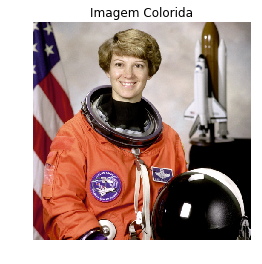

In [3]:
img = data.astronaut()
img_shape = img.shape
print("Tamanho da imagem: %d linhas, %d colunas, %d planos de cor" % img_shape)

f = plt.figure()
ax_img = f.gca()
ax_img.imshow(img)
ax_img.set_axis_off()
ax_img.set_title("Imagem Colorida");





No trecho abaixo, vamos separar e mostrar os três planos de cor (RGB).


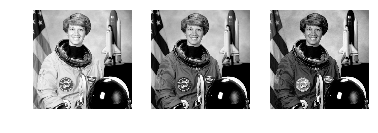

In [4]:
# red
img_r = img[:, :, 0]
# green
img_g = img[:, :, 1]
# blue
img_b = img[:, :, 2]

figura, (axr, axg, axb) = plt.subplots(nrows=1, ncols=3)
axr.imshow(img_r, cmap=plt.cm.gray)
axr.set_axis_off()
axg.imshow(img_g, cmap=plt.cm.gray)
axg.set_axis_off()
axb.imshow(img_b, cmap=plt.cm.gray)
axb.set_axis_off()






No modelo de cor RGB, o espaço de cores forma um cubo, pois cada componente r, g ou b pode varia num intervalo $\left[0, v_{max}\right]$. As coordenadas $(0, 0, 0)$, $(v_{max}, 0, 0)$, $(0, v_{max}, 0)$, $(0, 0, v_{max})$, $(v_{max}, v_{max}, 0)$, $(v_{max}, 0, v_{max})$, $(0, v_{max}, v_{max})$ e $(v_{max}, v_{max}, v_{max})$ formam os vértices desse cubo.

Se trabalharmos com 8 bits em cada plano de cor, então $v_{max} = 255$. Podemos visualizar os planos desse cubo se fixarmos o valor de um dos canais e variarmos os outros dois canais na faixa $[0, v_{max}]$.


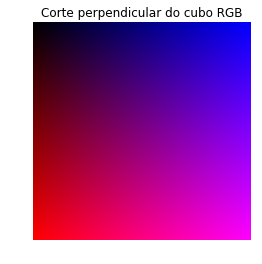

In [9]:
# vamos fixar o valor do canal verde em uma constante
G = 0

rows, cols = 256, 256
xidx = np.arange(rows)
yidx = np.arange(cols)
varia_vert, varia_horiz = np.meshgrid(xidx, yidx, indexing='ij')
constante = np.ones((rows, cols), dtype=varia_vert.dtype)

# vamos fazer a componente R variar verticalmente de 0 a 255
# a componente G vai ficar constante
# e a componente B vai variar horizontalmente de 0 a 255
r = varia_vert.astype(np.uint8)
g = (G*constante).astype(np.uint8)
b = varia_horiz.astype(np.uint8)

# concatena tres planos em uma imagem
plano_cubo_rgb = np.dstack((r, g, b))

f = plt.figure()
ax = f.gca()
ax.imshow(plano_cubo_rgb)
ax.set_axis_off()
ax.set_title("Corte perpendicular do cubo RGB");



**Exercício:** Varia o valor da componente verde dentro da faixa [0, 255] e observe o efeito sobre o plano de corte. Depois, altere o código para manter a componente R constante e variando G e B. Varie o valor de R e observe o efeito. Repita o procedimento, agora mantendo B constante e variando R e G.

Nós podemos converter uma imagem RGB para níveis de cinza fazendo a média aritmética dos três planos de cor:

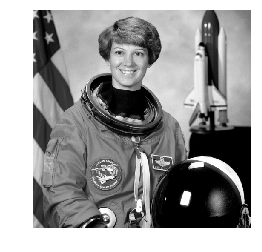

In [6]:
# no codigo abaixo é preciso converter os planos de cor antes de realizar a soma
# para evitar estouro da capacidade (overflow) do tipo 8 bits
img_cinza = (img_r.astype(np.float) + img_g.astype(np.float) + img_b.astype(np.float))/3;

mostra_imagem_cinza(img_cinza);

No entanto, a média aritmética simples pode não corresponder à nossa percepção de brilho. Outras ponderações podem resultar em resultados perceptualmente melhores, em função do dispositivo usado para saída (monitor, impressora, etc). É comum usarmos pesos diferentes ao fazer a conversão RGB -> luminância (Y).
$Y = a_rR + a_gG + a_bB$, com $a_r, a_g, a_b > 0$

**Exercício:** Implemente a conversão da imagem acima, usando $a_r = 0.2125$, $a_g = 0.7174$, $a_b = 0.0721$ (padrão adaptado para monitores comuns). Compare com o resultado anterior.

## Filtragem Espacial de Imagens Coloridas

Uma maneira de aplicar a filtragem espacial em imagens coloridas RGB é por meio dos seguintes passos:


1.   Separamos a imagem em três componentes r, g, b
2.   Aplicamos um filtro H em cada componente, obtendo H(r), H(g) e H(b)
3.   Concatenamos os três componentes H(r), H(g) e H(b) em uma única imagem colorida




**Exercício:** os trechos abaixo realizam a conversão da imagem para níveis de cinza e em seguida aplicam filtros de suavização/detecção de contornos. Modifique o código fornecido para aplicar os filtros de suavização/detecção de contornos sobre os componentes r, g,b, implementando o procedimento descrito acima.

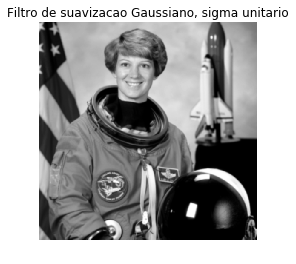

In [7]:
imagem_gray = color.rgb2gray(img)

resultado_gauss = gaussian(imagem_gray, sigma=1)
fg, axg = mostra_imagem_cinza(resultado_gauss)
axg.set_title('Filtro de suavizacao Gaussiano, sigma unitario');

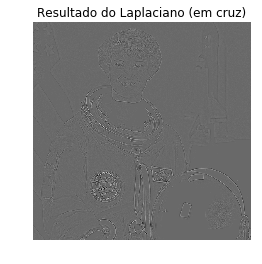

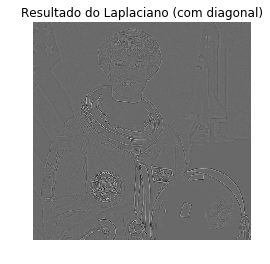

In [8]:
nabla2_cruz = np.array([[0,  -1,  0],
                        [-1,  4, -1],
                        [0,  -1,  0]], dtype=np.float32)
laplaciano1 = conv2(imagem_gray, nabla2_cruz, 'same')
f7, ax7 = mostra_imagem_cinza(laplaciano1)
ax7.set_title('Resultado do Laplaciano (em cruz)')

nabla2_diag = np.array([[-1,  -1,  -1],
                        [-1,  8, -1],
                        [-1,  -1,  -1]], dtype=np.float32)


laplaciano2 = conv2(imagem_gray, nabla2_diag, 'same')
f8, ax8 = mostra_imagem_cinza(laplaciano2)
ax8.set_title('Resultado do Laplaciano (com diagonal)');

